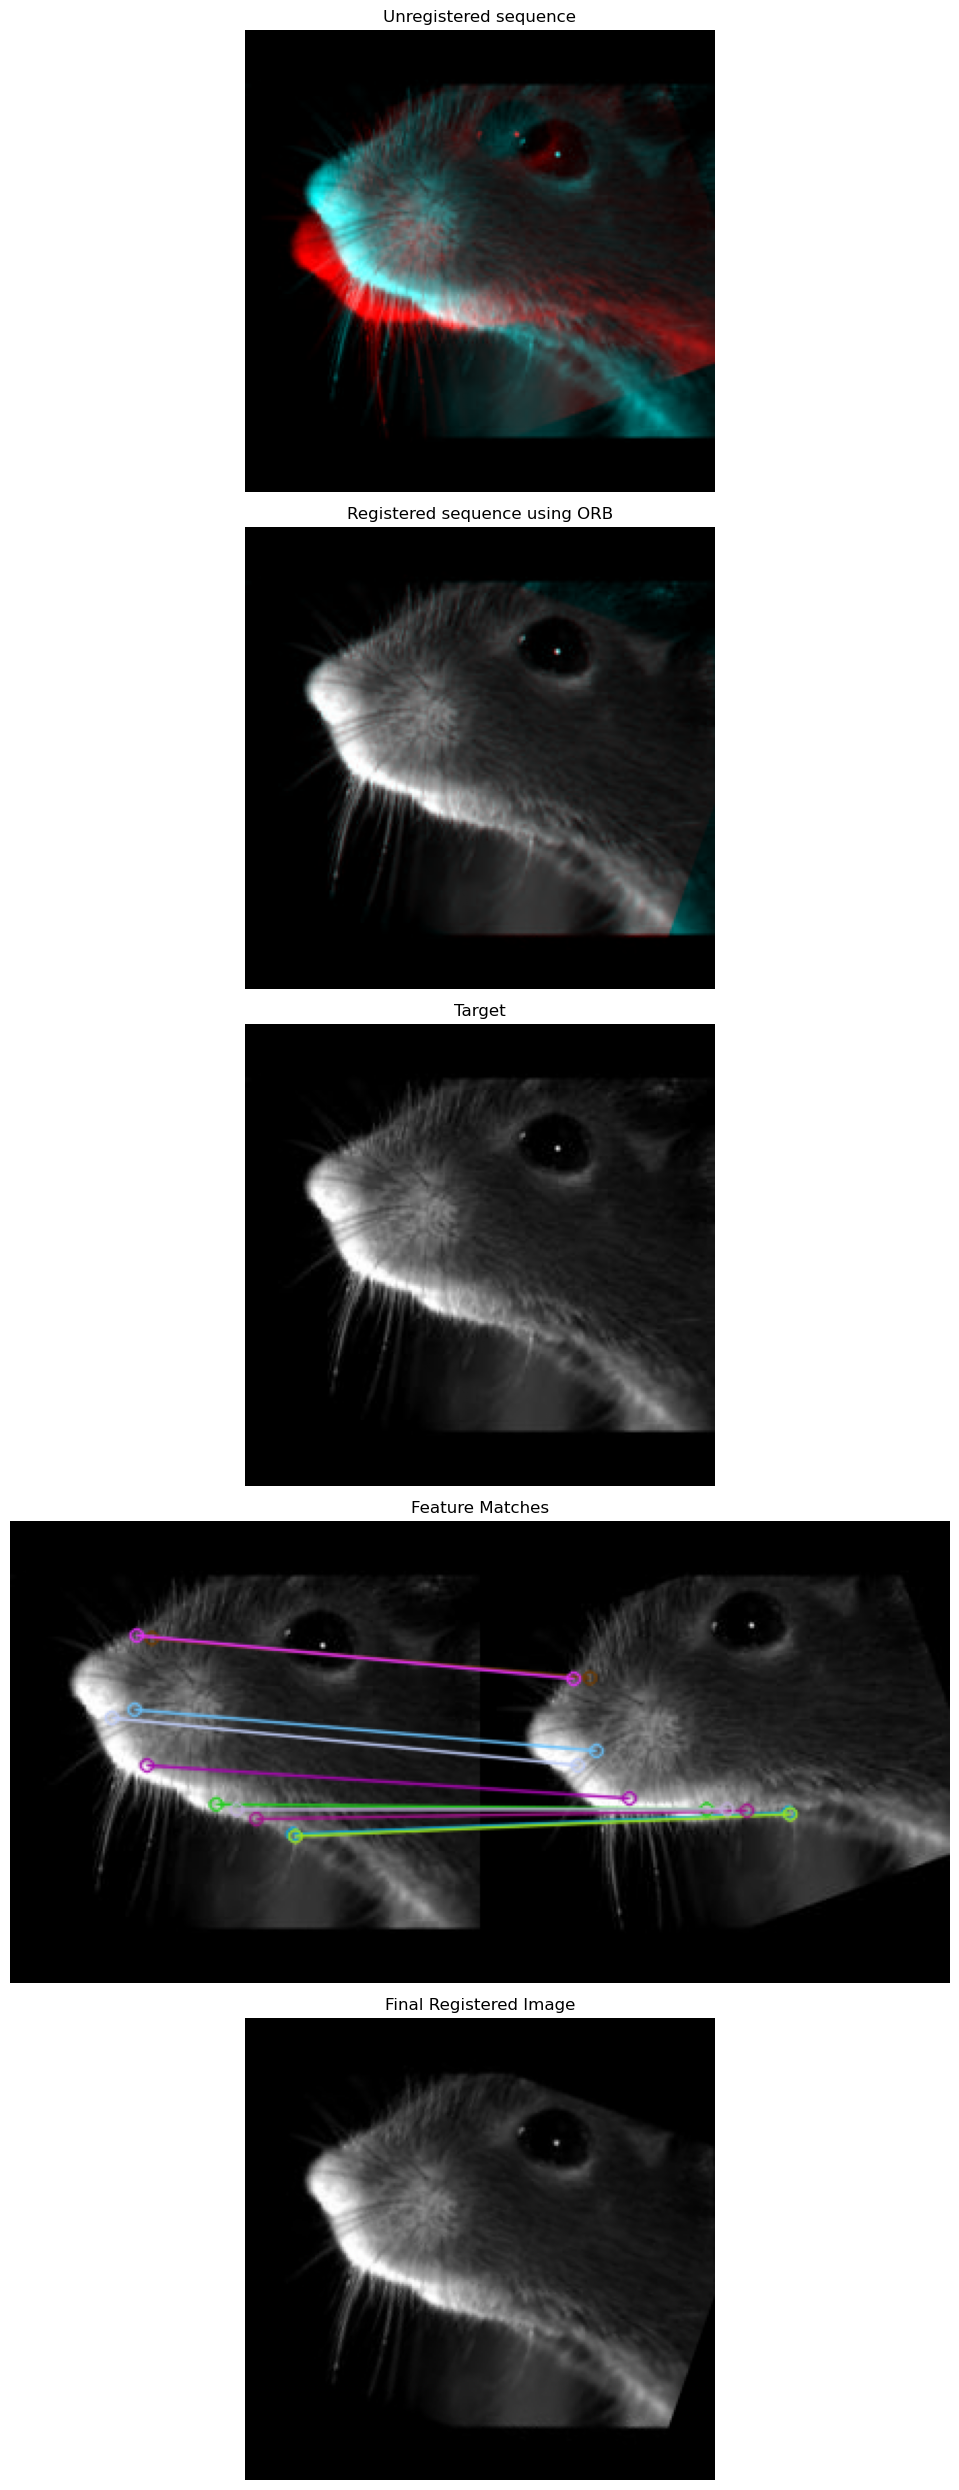

In [3]:
#Apply ORB detection and registration to single image, including showing which points will be aligned

import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage import io
import os

# --- Load the sequence
image1 = io.imread('Test_img9160_rotate_rescale_augmented.jpg')
image0 = io.imread('Target_img9160_pad_rescale_augmented.jpg')

# --- Convert the images to gray level: color is not supported.
image0_gray = rgb2gray(image0)
image1_gray = rgb2gray(image1)

# Convert images to uint8
image0_gray_uint8 = (image0_gray * 255).astype(np.uint8)
image1_gray_uint8 = (image1_gray * 255).astype(np.uint8)

# --- Feature matching using ORB
orb = cv2.ORB_create()

# Find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(image0_gray_uint8, None)
kp2, des2 = orb.detectAndCompute(image1_gray_uint8, None)

# Create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors
matches = bf.match(des1, des2)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw first 10 matches (for visualization purposes)
img_matches = cv2.drawMatches(image0_gray_uint8, kp1, image1_gray_uint8, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# --- Estimate homography matrix using matched features
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

# --- Warp image1 to image0 using the homography matrix
image1_warp = cv2.warpPerspective(image1, M, (image0.shape[1], image0.shape[0]))

# --- Build RGB images for visualization
nr, nc = image0.shape[:2]

# build an RGB image with the unregistered sequence
seq_im = np.zeros((nr, nc, 3))
seq_im[..., 0] = image1_gray
seq_im[..., 1] = image0_gray
seq_im[..., 2] = image0_gray

# build an RGB image with the registered sequence
reg_im = np.zeros((nr, nc, 3))
reg_im[..., 0] = rgb2gray(image1_warp)
reg_im[..., 1] = image0_gray
reg_im[..., 2] = image0_gray

# build an RGB image with the target sequence
target_im = np.zeros((nr, nc, 3))
target_im[..., 0] = image0_gray
target_im[..., 1] = image0_gray
target_im[..., 2] = image0_gray

# Use the actual warped image for final display without converting to grayscale
final_reg_im = image1_warp

# --- Show the result
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(10, 25))

ax0.imshow(seq_im)
ax0.set_title("Unregistered sequence")
ax0.set_axis_off()

ax1.imshow(reg_im)
ax1.set_title("Registered sequence using ORB")
ax1.set_axis_off()

ax2.imshow(target_im)
ax2.set_title("Target")
ax2.set_axis_off()

ax3.imshow(img_matches)
ax3.set_title("Feature Matches")
ax3.set_axis_off()

ax4.imshow(final_reg_im)
ax4.set_title("Final Registered Image")
ax4.set_axis_off()

fig.tight_layout()
plt.show()


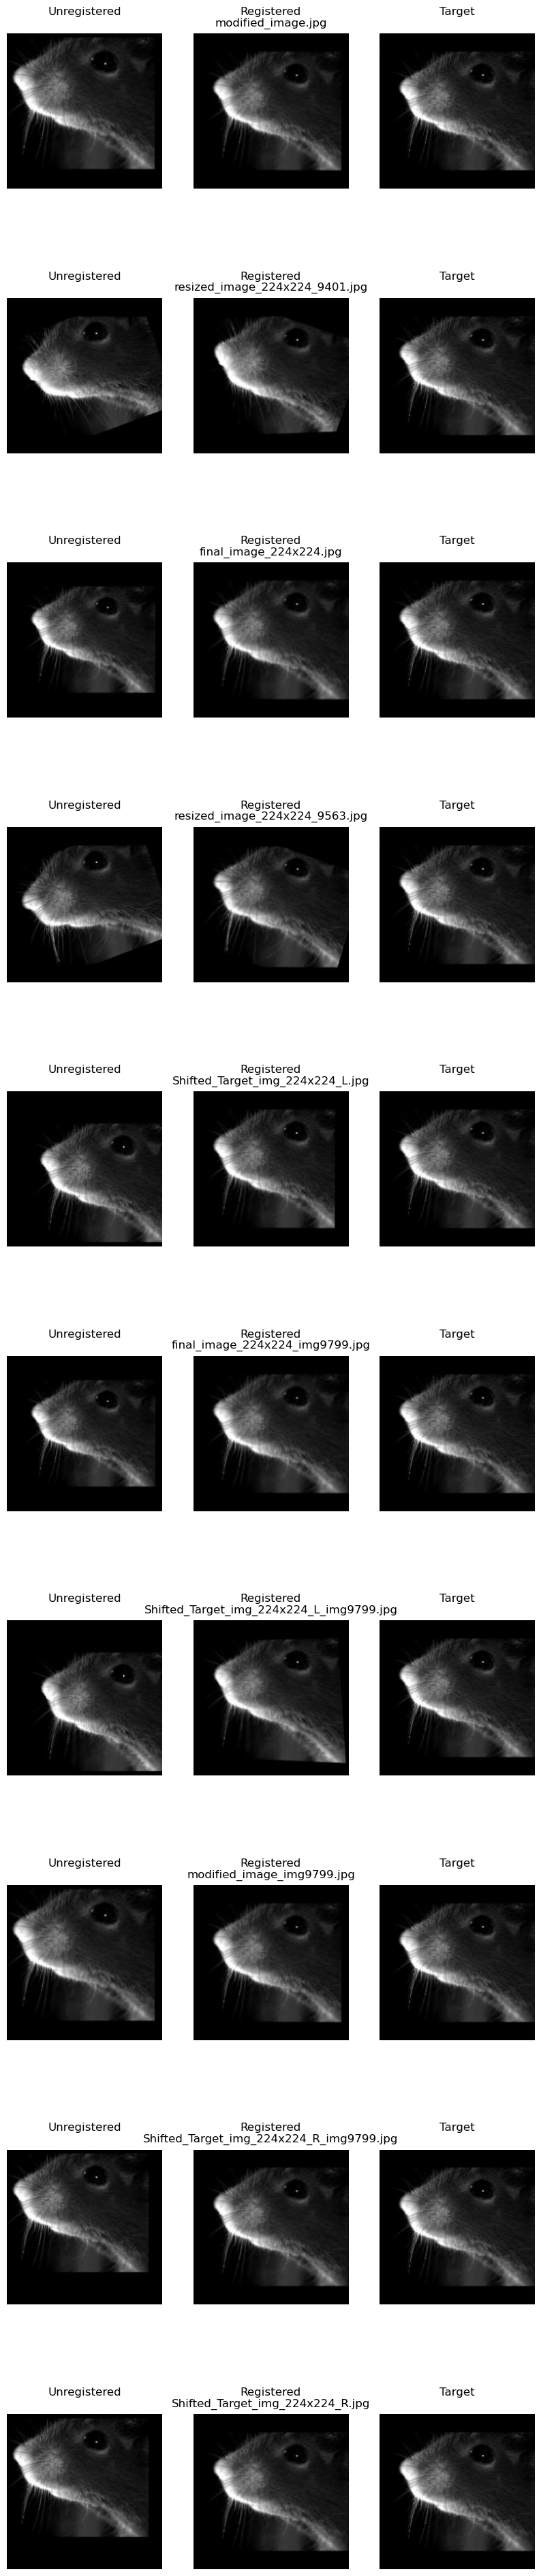

In [4]:
#apply ORB detection and registration to a list of images in a folder, and show original image, registered image, and target

# Load the target image
image0 = io.imread('Target_img9160_resized_image_224x224.jpg')
image0_gray = rgb2gray(image0)

# Paths to the folders containing images
folder_path = 'Modified_images'
registered_folder_path = 'Registered_Images'
os.makedirs(registered_folder_path, exist_ok=True)
images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg')) and not img.startswith('.')]

# Prepare the figure for plotting
fig, axs = plt.subplots(len(images), 3, figsize=(10, 5 * len(images)))

for i, img_name in enumerate(images):
    image_path = os.path.join(folder_path, img_name)
    image1 = io.imread(image_path)
    image1_gray = rgb2gray(image1)

    # Convert images to uint8
    image0_gray_uint8 = (image0_gray * 255).astype(np.uint8)
    image1_gray_uint8 = (image1_gray * 255).astype(np.uint8)

    # --- Feature matching using ORB
    orb = cv2.ORB_create()

    # Find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(image0_gray_uint8, None)
    kp2, des2 = orb.detectAndCompute(image1_gray_uint8, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors
    matches = bf.match(des1, des2)

    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Estimate homography matrix using matched features
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Warp image1 to image0 using the homography matrix
    image1_warp = cv2.warpPerspective(image1, M, (image0.shape[1], image0.shape[0]))

    # Save the registered image
    save_path = os.path.join(registered_folder_path, f"registered_{img_name}")
    plt.imsave(save_path, image1_warp)

    # Display the images
    axs[i, 0].imshow(image1_gray, cmap='gray')
    axs[i, 0].set_title("Unregistered", pad=20)
    axs[i, 0].set_axis_off()

    axs[i, 1].imshow(rgb2gray(image1_warp), cmap='gray')
    axs[i, 1].set_title("Registered", pad=20)
    axs[i, 1].set_axis_off()

    axs[i, 2].imshow(image0_gray, cmap='gray')
    axs[i, 2].set_title("Target", pad=20)
    axs[i, 2].set_axis_off()

    # Place image name above the plots
    axs[i, 1].annotate(img_name, (0.5, 1), xycoords='axes fraction', ha='center', va='bottom', fontsize=12, xytext=(0, 5), textcoords='offset points')

# Adjust the space between rows of images
plt.subplots_adjust(hspace=0.1)
plt.show()
